In [ ]:
def to_device(x, device="cuda:0"):
    if isinstance(x, dict):
        return {k: to_device(v) for k, v in x.items()}
    return x.to(device=device)

# Load Model

In [ ]:
!pip install -qU transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.9 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
from transformers import CLIPModel, CLIPConfig, CLIPVisionModel
from transformers import AutoModel, AutoTokenizer

In [ ]:
text_tokenizer = AutoTokenizer.from_pretrained('arman-aminian/farsi-image-search-text')
text_encoder = AutoModel.from_pretrained('arman-aminian/farsi-image-search-text').to(device='cuda:0')
image_encoder = CLIPVisionModel.from_pretrained('arman-aminian/farsi-image-search-vision').to(device='cuda:0')

# STL10 dataset

In [ ]:
label_to_text =  {
      0: 'این عکس یک هواپیما است.',
      1: 'این عکس یک پرنده است.',
      2: 'این عکس یک ماشین است.',
      3: 'این عکس یک گربه است.',
      4: 'این عکس یک آهو است.',
      5: 'این عکس یک سگ است.',
      6: 'این عکس یک اسب است.',
      7: 'این عکس یک میمون است.',
      8: 'این عکس یک کشتی است.',
      9: 'این عکس یک کامیون است.'
}


In [ ]:
from torchvision.datasets import STL10

stl10_dataset = STL10(root='STL10-dataset', download=True, folds=1)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting STL10-dataset/stl10_binary.tar.gz to STL10-dataset


9


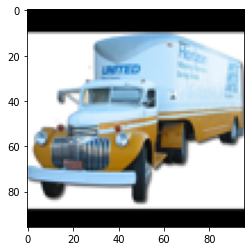

In [ ]:
import matplotlib.pyplot as plt

image, label = stl10_dataset[20]

plt.imshow(image)
print(label)

## Text Embedding

In [ ]:
from tqdm import tqdm
import torch

In [ ]:
def calc_embedding_for_text(text):
    with torch.no_grad():
        tokenized = text_tokenizer(text, return_tensors='pt')
        embedding = text_encoder(**to_device(tokenized)).pooler_output
    return embedding.squeeze().cpu().tolist()

In [ ]:
text_embeddings = []
for text in tqdm(label_to_text.values()):
  text_embeddings.append(calc_embedding_for_text(text))

100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


## Image Embedding

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
def calc_embedding_for_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]), 
            std=torch.tensor([0.229, 0.224, 0.225]),
        )
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        embedding = image_encoder(to_device(image)).pooler_output
    return embedding.squeeze().cpu().tolist()

In [ ]:
image_embeddings = []
for image, _ in tqdm(stl10_dataset):
    image_embeddings.append(calc_embedding_for_image(image))

100%|██████████| 1000/1000 [00:15<00:00, 64.71it/s]


## Pairwise Cosine Similarity

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(emb1, emb2):
    cos_sim = dot(emb1, emb2) / (norm(emb1) * norm(emb2))
    return cos_sim

In [ ]:
cosine_matrix = []
for image_embedding in tqdm(image_embeddings):
    cosine_matrix.append([cosine_similarity(image_embedding, text_embedding) for text_embedding in text_embeddings ])

100%|██████████| 1000/1000 [00:02<00:00, 400.50it/s]


In [ ]:
predicted_labels = []
true_labels = []


for i in range(len(cosine_matrix)):
  predicted_labels.append(cosine_matrix[i].index(max(cosine_matrix[i])))
  true_labels.append(stl10_dataset[i][1])

## Evaluation

In [ ]:
from sklearn.metrics import classification_report


report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.64      0.21      0.32       100
           1       0.56      0.14      0.22       100
           2       0.69      0.90      0.78       100
           3       0.49      0.40      0.44       100
           4       0.10      0.08      0.09       100
           5       0.28      0.91      0.43       100
           6       0.66      0.67      0.66       100
           7       0.00      0.00      0.00       100
           8       0.69      0.83      0.75       100
           9       0.76      0.77      0.77       100

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.45      1000
weighted avg       0.49      0.49      0.45      1000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# OxfordIIITPet

In [ ]:
from torchvision.datasets import OxfordIIITPet

In [ ]:
pet_dataset = OxfordIIITPet(root='pet-dataset', download=True)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting pet-dataset/oxford-iiit-pet/images.tar.gz to pet-dataset/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting pet-dataset/oxford-iiit-pet/annotations.tar.gz to pet-dataset/oxford-iiit-pet


In [ ]:
dog_text = 'این عکس یک سگ، یک نوع حیوان خانگی است.'
cat_text = 'این عکس یک گربه، یک نوع حیوان خانگی است.'


pets_text = [dog_text, cat_text]

pet_label_transform =  {
    0: 1,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 1,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 0,
    11: 1,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 1,
    21: 0,
    22: 0,
    23: 1,
    24: 0,
    25: 0,
    26: 1,
    27: 1,
    28: 0,
    29: 0,
    30: 0,
    31: 0,
    32: 1,
    33: 1,
    34: 0,
    35: 0,
    36: 0,
}

# Text Embedding

In [ ]:
from tqdm import tqdm
import torch

def calc_embedding_for_text(text):
    with torch.no_grad():
        tokenized = text_tokenizer(text, return_tensors='pt')
        embedding = text_encoder(**to_device(tokenized)).pooler_output
    return embedding.squeeze().cpu().tolist()

text_embeddings = []
for text in tqdm(pets_text):
  text_embeddings.append(calc_embedding_for_text(text))

100%|██████████| 2/2 [00:00<00:00, 52.25it/s]


# Image Embedding

In [ ]:
import torchvision.transforms as transforms
from PIL import Image


def calc_embedding_for_image(image):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=torch.tensor([0.485, 0.456, 0.406]), 
            std=torch.tensor([0.229, 0.224, 0.225]),
        )
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        embedding = image_encoder(to_device(image)).pooler_output
    return embedding.squeeze().cpu().tolist()


image_embeddings = []
for image, _ in tqdm(pet_dataset):
    image_embeddings.append(calc_embedding_for_image(image))

100%|██████████| 3680/3680 [01:09<00:00, 52.62it/s]


# Cosine Similarity

In [ ]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(emb1, emb2):
    cos_sim = dot(emb1, emb2) / (norm(emb1) * norm(emb2))
    return cos_sim

In [ ]:
cosine_matrix = []
for image_embedding in tqdm(image_embeddings):
    cosine_matrix.append([cosine_similarity(image_embedding, text_embedding) for text_embedding in text_embeddings ])

100%|██████████| 3680/3680 [00:02<00:00, 1448.74it/s]


In [ ]:
predicted_labels = []
true_labels = []

for i in range(len(cosine_matrix)):
  predicted_labels.append(cosine_matrix[i].index(max(cosine_matrix[i])))
  true_labels.append(pet_label_transform[pet_dataset[i][1]])


## Evaluation

In [ ]:
from sklearn.metrics import classification_report


report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2492
           1       0.80      0.64      0.71      1188

    accuracy                           0.83      3680
   macro avg       0.82      0.78      0.80      3680
weighted avg       0.83      0.83      0.83      3680

